In [2]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import SpectralEmbedding
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook

In [3]:
# Read in the basketball-reference dataframe
df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Basketball-reference data\df_with_all_positions_and_teams(2001-2024).csv")
df.set_index(['Season', 'Team', 'Player', 'Pos'], inplace=True)

In [4]:
# Cleaning up the dataframe
df.rename(columns = {'PF': 'Personal Fouls Committed'}, inplace=True)
df.rename(columns = {'Fouls Drawn - Shoot': 'Shooting Fouls Drawn'}, inplace=True)
df.drop(columns = ['% of FGA by Distance - 2P', 'FG'], inplace=True)

# Removing any players named "Player"
df.reset_index(inplace=True)
df = df[df['Player'] != 'Player']
df.set_index(['Season', 'Team', 'Player', 'Pos'], inplace=True)

# Changing all the values in the df to be floats so that I can apply PCA
df.fillna(0, inplace=True)  # Filling NaNs with 0
df = df.astype(float)

# Replacing any infinite values with 0
df.replace([np.inf, -np.inf], 0, inplace=True)

# Changing necessary stats to per 48 minutes
per_48_stats = ['FGA', 'Personal Fouls Committed', 'BLK', 'STL', 'DRB', 'ORB', 'TOV', 'AST']

for stat in per_48_stats:
    df[stat] = df[stat] / (df['MP'] / df['G']) * 48


# Reordering the columns
ordered_cols = ['G', 'MP', 'USG%', 'FGA', 'Personal Fouls Committed', 'BLK', 'STL', 'DRB', 'ORB', 'TOV', 'AST', "% of FG Ast'd - 3P", "% of FG Ast'd - 2P", 'FTr', 'Shooting Fouls Drawn', 'Corner 3s - %3PA', '% of FGA by Distance - 3P', '% of FGA by Distance - 16-3P', '% of FGA by Distance - 10-16', '% of FGA by Distance - 3-10', '% of FGA by Distance - 0-3', 'Dunks - %FGA', ]
df = df.reindex(columns = ordered_cols)

# Drop the Shooting Fouls column
df = df.drop(columns = 'Shooting Fouls Drawn')

# Dropping more unnecessary columns
df.drop(columns = ['Dunks - %FGA', 'Personal Fouls Committed'], inplace=True)
df['TRB'] = df['ORB'] + df['DRB']
df = df.drop(columns = ['ORB', 'DRB'])

In [5]:
# Creating a MPG column instead of the total minutes played
df['MPG'] = df['MP'] / df['G']
df = df.drop(columns = ['MP'])
df = df.reset_index()

In [6]:
df

,Season,Team,Player,Pos,G,USG%,FGA,BLK,STL,TOV,...,% of FG Ast'd - 2P,FTr,Corner 3s - %3PA,% of FGA by Distance - 3P,% of FGA by Distance - 16-3P,% of FGA by Distance - 10-16,% of FGA by Distance - 3-10,% of FGA by Distance - 0-3,TRB,MPG
0,2001,MIA,A.C. Green,PF,82.0,14.4,11.158044,0.278951,1.115804,1.394755,...,0.764,0.343,0.167,0.019,0.438,0.164,0.102,0.278,10.600142,17.207317
1,2001,CHI,A.J. Guyton,PG,33.0,16.5,14.582857,0.502857,0.754286,1.760000,...,0.608,0.094,0.275,0.359,0.427,0.094,0.042,0.078,2.765714,19.090909
2,2001,PHI,Aaron McKie,SG,76.0,18.9,14.323810,0.152381,2.133333,4.114286,...,0.481,0.272,0.359,0.238,0.209,0.183,0.137,0.232,6.247619,31.500000
3,2001,NJN,Aaron Williams,PF,82.0,17.8,13.310959,2.358904,1.179452,2.695890,...,0.623,0.477,0.000,0.003,0.103,0.131,0.262,0.502,12.131507,28.487805
4,2001,GSW,Adam Keefe,PF,67.0,11.5,9.232536,1.154067,1.538756,2.308134,...,0.683,0.396,0.333,0.019,0.258,0.170,0.176,0.377,11.925359,12.477612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13205,2024,CHI,Zach LaVine,SG,25.0,23.8,20.642202,0.412844,1.100917,2.889908,...,0.396,0.274,0.183,0.449,0.125,0.053,0.136,0.237,7.018349,34.880000
13206,2024,MEM,Zavier Simpson,PG,7.0,17.5,16.069565,0.834783,2.086957,2.921739,...,0.250,0.074,0.118,0.315,0.093,0.093,0.333,0.167,6.052174,23.000000
13207,2024,DEN,Zeke Nnaji,PF,58.0,15.4,12.566667,3.383333,1.450000,2.416667,...,0.619,0.416,0.391,0.154,0.007,0.027,0.215,0.597,10.633333,9.931034
13208,2024,MEM,Ziaire Williams,SF,51.0,19.7,17.452023,0.471676,1.650867,3.065896,...,0.641,0.198,0.370,0.500,0.069,0.085,0.127,0.220,8.254335,20.352941


In [7]:
# Defining lists for each season and team in the seasons
seasons = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
teams = df.reset_index()['Team'].unique().tolist()

In [8]:
# Creating a dictionary of individual rosters with proper weighting
roster_dfs = {}
for season in seasons:
    season_df = df[df['Season'] == season].copy()
    max_mp = season_df['MPG'].max()
    max_gp = season_df['G'].max()
    season_df['Player Weight'] = (0.7 * (season_df['MPG'] / max_mp)) + (0.3 * (season_df['G'] / max_gp))
    season_df = season_df.set_index(['Season', 'Team', 'Player', 'Pos', 'G', 'MPG'])
    for column in season_df.columns:
        if column != 'Player Weight':
            season_df[column] = season_df[column] * season_df['Player Weight']
    season_df = season_df.reset_index()
    for team in teams:
        if team in season_df['Team'].unique().tolist():
            team_df = season_df[season_df['Team'] == team].sort_values(by = 'Player Weight', ascending = False).head(9)
            team_df = team_df.set_index('Player')
            roster_dfs[str(season)+team] = team_df.drop(columns = ['Season', 'Team', 'Pos', 'G', 'MPG', 'Player Weight'])

In [9]:
aggregate_dfs = []
for roster in roster_dfs:
    aggregate_df = pd.DataFrame(roster_dfs[roster].mean()).T
    aggregate_df['Roster'] = roster
    aggregate_dfs.append(aggregate_df)
aggregates_df = pd.concat(aggregate_dfs, ignore_index=True).set_index('Roster')

In [10]:
aggregates_df

,USG%,FGA,BLK,STL,TOV,AST,% of FG Ast'd - 3P,% of FG Ast'd - 2P,FTr,Corner 3s - %3PA,% of FGA by Distance - 3P,% of FGA by Distance - 16-3P,% of FGA by Distance - 10-16,% of FGA by Distance - 3-10,% of FGA by Distance - 0-3,TRB
Roster,,,,,,,,,,,,,,,,
2001MIA,14.718647,11.119506,0.679186,1.113648,1.939690,2.911115,0.336181,0.406438,0.226507,0.094051,0.176192,0.161776,0.107894,0.108278,0.183090,5.983500
2001CHI,14.373478,11.385495,0.540390,1.208207,2.029441,3.366040,0.537979,0.435861,0.199752,0.195628,0.128284,0.178461,0.114477,0.094424,0.184744,5.110495
2001PHI,14.281575,11.065760,0.911429,1.192326,2.257909,2.994245,0.423150,0.406195,0.279576,0.122912,0.076487,0.117604,0.157956,0.167588,0.210909,6.877866
2001NJN,14.710140,11.891080,0.712652,1.185972,1.967071,2.679632,0.501012,0.414561,0.240679,0.119460,0.107388,0.168473,0.095731,0.102919,0.246872,5.798146
2001GSW,14.555899,12.653450,0.662977,1.211110,2.165906,3.132281,0.492624,0.377077,0.237184,0.097077,0.104155,0.161265,0.114217,0.160751,0.174698,7.029386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024MEM,16.017445,14.050917,0.711016,1.043312,2.243979,3.936655,0.583392,0.347840,0.176838,0.142844,0.333652,0.023634,0.045282,0.142604,0.147163,5.271173
2024OKC,14.843881,13.339354,0.953770,1.283633,1.702537,3.834423,0.628897,0.411209,0.154182,0.179041,0.295815,0.040103,0.074911,0.131444,0.188559,5.992650
2024BRK,14.749015,13.242605,0.694353,1.014782,1.786429,4.220275,0.635657,0.374552,0.159040,0.233627,0.335964,0.034923,0.064597,0.136117,0.173274,5.725334


In [11]:
# Normalizing the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(aggregates_df)
standardized_df = pd.DataFrame(standardized_data, columns=aggregates_df.columns, index=aggregates_df.index)

In [12]:
standardized_df

,USG%,FGA,BLK,STL,TOV,AST,% of FG Ast'd - 3P,% of FG Ast'd - 2P,FTr,Corner 3s - %3PA,% of FGA by Distance - 3P,% of FGA by Distance - 16-3P,% of FGA by Distance - 10-16,% of FGA by Distance - 3-10,% of FGA by Distance - 0-3,TRB
Roster,,,,,,,,,,,,,,,,
2001MIA,0.096432,-1.202856,-0.059867,0.150377,-0.271078,-0.965902,-2.313741,0.756652,0.645407,-1.753118,-0.282707,0.790132,1.373139,-0.233839,-0.891035,-0.196473
2001CHI,-0.416111,-0.917515,-1.041335,0.837987,0.207491,0.035361,0.171689,1.479019,-0.219071,0.629132,-0.967110,1.105428,1.680472,-0.759358,-0.841259,-1.919088
2001PHI,-0.552579,-1.260512,1.582384,0.722505,1.425724,-0.782936,-1.242594,0.750677,2.360112,-1.076251,-1.707077,-0.044630,3.710583,2.015966,-0.053776,1.568290
2001NJN,0.083800,-0.375147,0.176782,0.676298,-0.125077,-1.475380,-0.283616,0.956089,1.103317,-1.157213,-1.265631,0.916676,0.805193,-0.437116,1.028565,-0.562215
2001GSW,-0.145234,0.442687,-0.174489,0.859092,0.935145,-0.479128,-0.386920,0.035827,0.990404,-1.682146,-1.311826,0.780458,1.668350,1.756595,-1.143604,1.867269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024MEM,2.025026,1.941822,0.165211,-0.361083,1.351448,1.291250,0.731008,-0.681985,-0.959418,-0.608783,1.966751,-1.820423,-1.550301,1.068251,-1.972321,-1.602037
2024OKC,0.282392,1.178491,1.881786,1.386460,-1.535622,1.066244,1.291469,0.873783,-1.691454,0.240121,1.426207,-1.509194,-0.166898,0.644906,-0.726439,-0.178418
2024BRK,0.141526,1.074704,0.047383,-0.568547,-1.088294,1.915480,1.374719,-0.026179,-1.534500,1.520327,1.999776,-1.607087,-0.648454,0.822181,-1.186462,-0.705887


In [13]:
# Setting up PCA to keep only the first 5 components
pca = PCA(n_components=5)
principal_components = pca.fit_transform(standardized_df)

# Summing the explained variances for each component to verify the results from the paper
explained_variance = pca.explained_variance_ratio_
sum(explained_variance)

0.6946582378207822

In [14]:
explained_variance

array([0.29799648, 0.14545999, 0.09318588, 0.08440468, 0.0736112 ])

In [15]:
# Getting the statistics for each individual principal component
component_loadings = pca.components_
loadings_df = pd.DataFrame(component_loadings, columns=standardized_df.columns, index=[f'PC{i+1}' for i in range(5)])
loadings_df

,USG%,FGA,BLK,STL,TOV,AST,% of FG Ast'd - 3P,% of FG Ast'd - 2P,FTr,Corner 3s - %3PA,% of FGA by Distance - 3P,% of FGA by Distance - 16-3P,% of FGA by Distance - 10-16,% of FGA by Distance - 3-10,% of FGA by Distance - 0-3,TRB
PC1,0.279040,0.404113,0.019422,0.124959,0.067871,0.347225,0.297095,0.010314,-0.250109,0.080338,0.402854,-0.363981,-0.224027,0.231929,-0.130447,0.210991
PC2,-0.250147,-0.087122,-0.331412,-0.298129,-0.377811,-0.025685,0.023842,-0.265491,-0.351646,-0.001643,0.139557,-0.084378,0.016071,0.073589,-0.490143,-0.347130
PC3,-0.022465,-0.006065,0.207688,0.179847,-0.263468,0.245500,0.186321,0.595832,-0.236515,0.160286,-0.115900,0.229337,0.431818,-0.087837,-0.249729,-0.018872
PC4,-0.041726,0.058639,0.340013,-0.232844,0.029795,-0.075412,-0.299071,0.004443,-0.082073,-0.518412,-0.088222,-0.125951,0.288729,0.442101,-0.211309,0.326119
PC5,0.427089,0.203239,-0.459398,0.106726,0.380677,0.156469,-0.013301,-0.070440,0.010813,-0.332172,-0.147695,0.251165,0.292917,-0.007772,-0.169446,-0.263421


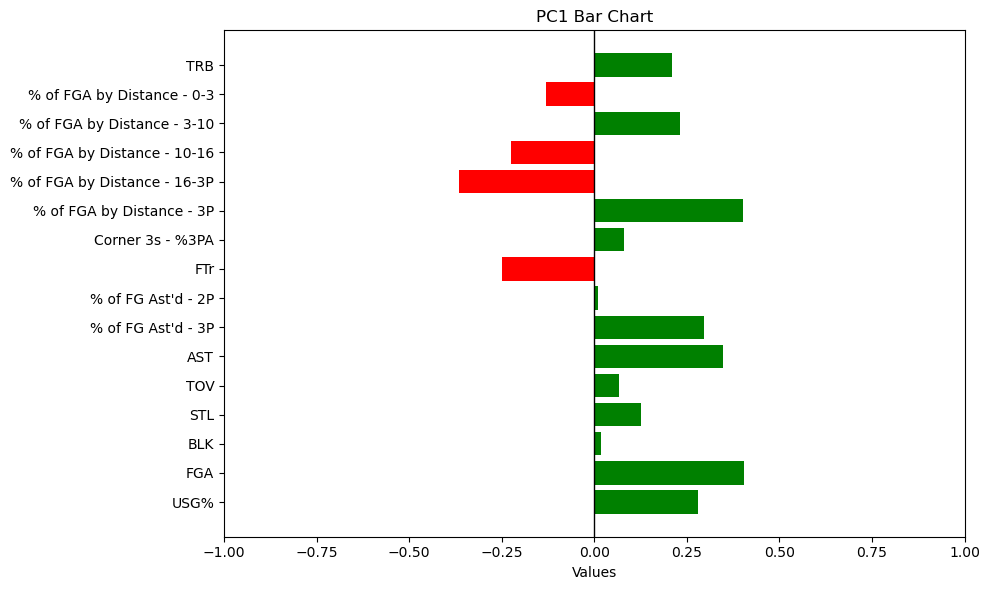

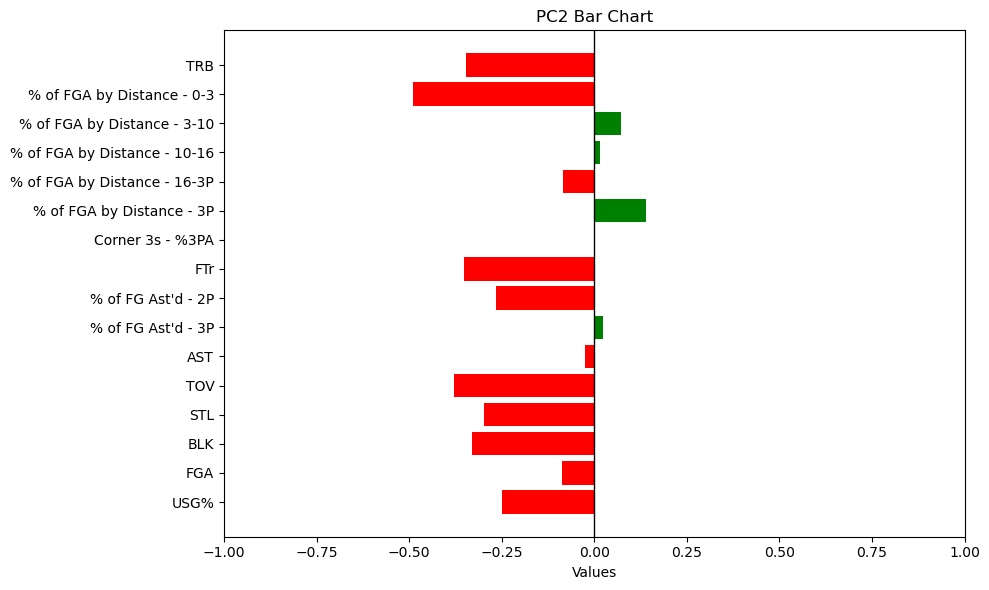

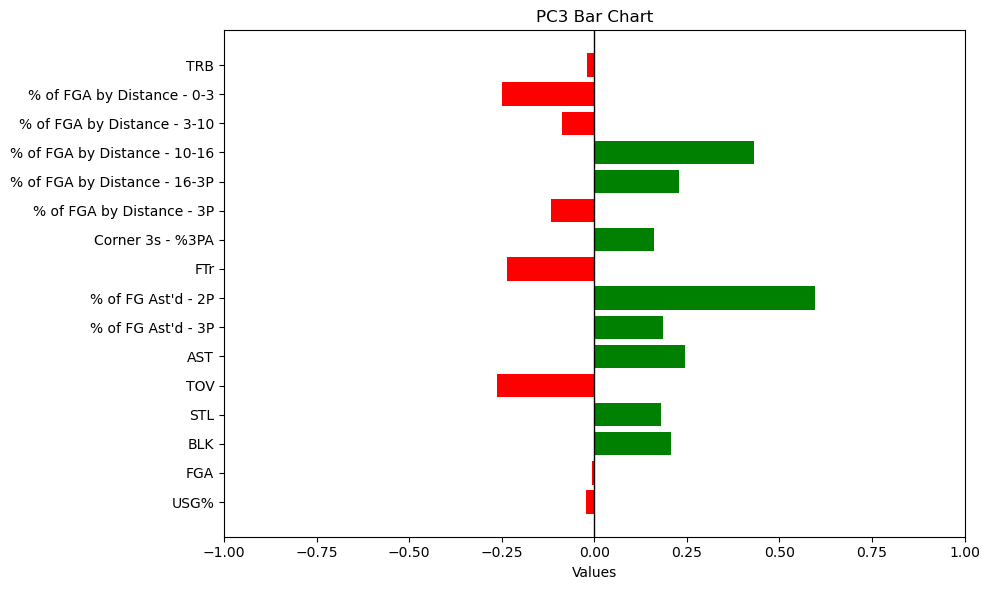

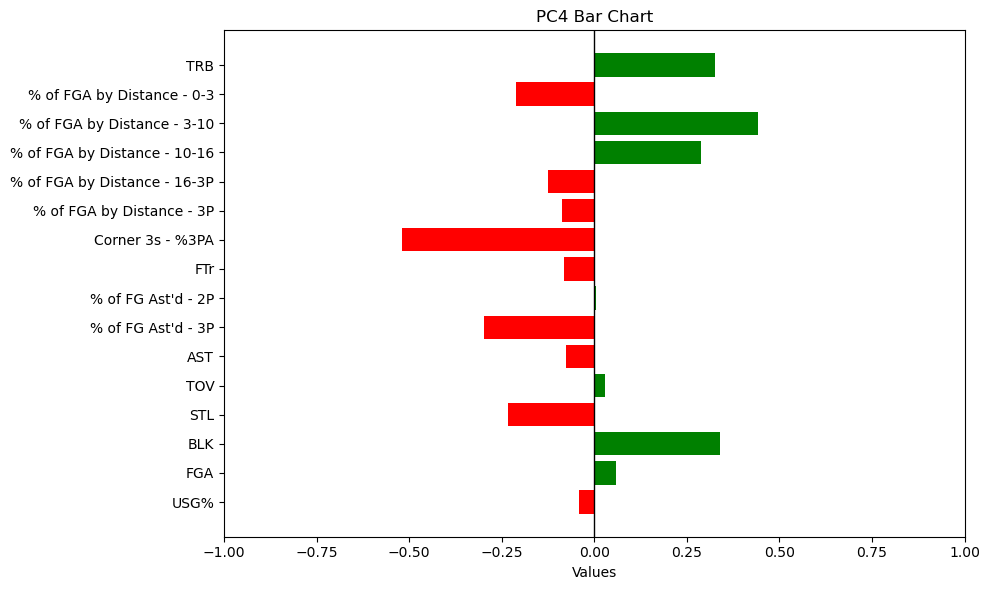

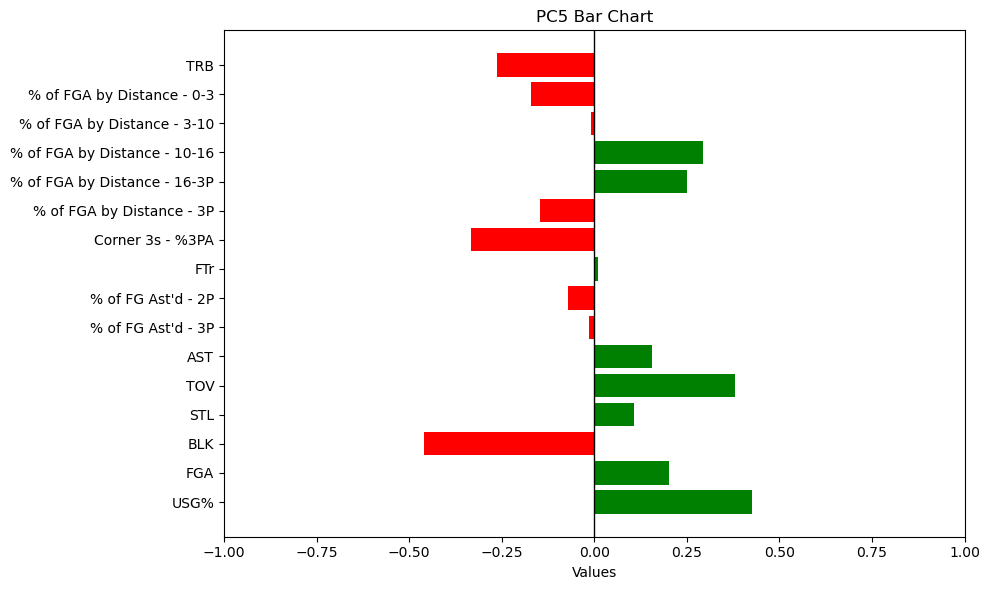

In [16]:
# Looping through each row to create individual plots
for i, row in loadings_df.iterrows():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Make the bar green if the value is positive, red if it is negative
    colors = ['green' if val >= 0 else 'red' for val in row]
    
    ax.barh(loadings_df.columns, row, color=colors)
    
    # Add vertical line at x=0
    ax.axvline(0, color='black', linewidth=1)
    
    # Center each graph at 0 and range from -1 to 1 for consistency
    ax.set_xlim(-1, 1)
    
    # Set titles and labels
    ax.set_title(f'{i} Bar Chart')
    ax.set_xlabel('Values')
    
    plt.tight_layout()
    plt.show()

In [17]:
# Applying the PCA transformation to get the principal component scores for each player
pca_scores = pca.transform(standardized_df)

# Converting to DataFrame
pca_scores_df = pd.DataFrame(pca_scores, columns=[f'PC{i+1}' for i in range(5)], index=standardized_df.index)

In [18]:
pca_scores_df

,PC1,PC2,PC3,PC4,PC5
Roster,,,,,
2001MIA,-2.465754,0.106456,0.493806,1.828757,0.999714
2001CHI,-1.844162,0.708831,2.373520,-1.287564,1.537035
2001PHI,-2.453086,-2.611923,0.992510,3.801313,0.533022
2001NJN,-2.382448,-1.392195,0.396630,0.217846,0.635025
2001GSW,-0.593736,-1.086280,0.347732,2.869617,1.619617
...,...,...,...,...,...
2024MEM,4.218388,1.374883,-1.153703,0.259946,1.637849
2024OKC,3.233831,0.524842,2.037484,0.276650,-1.424424
2024BRK,3.641350,2.254902,0.859078,-0.821983,-0.964548


In [19]:
# Filtering out some of the 3-point-related stats to see if it affects our Laplacian Eigenmaps
#standardized_df = standardized_df.drop(columns = ['% of FGA by Distance - 3P', '% of FGA by Distance - 16-3P', "% of FG Ast'd - 3P"])

In [20]:
# Querying for only stats that had no long-term trend
#standardized_df = standardized_df.drop(columns=[col for col in standardized_df.columns if col not in ['BLK', 'STL', 'TOV', "% of FG Ast'd - 2P", 'Corner 3s - %3PA', 'TRB']])

In [21]:
embedding = SpectralEmbedding(n_components=2, affinity='rbf')
transformed_data = embedding.fit_transform(standardized_df)

In [22]:
le_df = pd.DataFrame(transformed_data, index=standardized_df.index, columns = ['LE_Component_1', 'LE_Component_2']).reset_index()

In [23]:
le_df = pd.merge(le_df.reset_index(), pca_scores_df.reset_index(), on='Roster').set_index('Roster')

In [24]:
le_df = pd.merge(le_df.reset_index(), aggregates_df.reset_index().drop(columns=[col for col in aggregates_df.columns if col != '% of FGA by Distance - 3P']), on='Roster')

In [25]:
le_df

,Roster,index,LE_Component_1,LE_Component_2,PC1,PC2,PC3,PC4,PC5,% of FGA by Distance - 3P
0,2001MIA,0,-0.003613,-0.000488,-2.465754,0.106456,0.493806,1.828757,0.999714,0.176192
1,2001CHI,1,-0.002703,0.000701,-1.844162,0.708831,2.373520,-1.287564,1.537035,0.128284
2,2001PHI,2,-0.004050,-0.005367,-2.453086,-2.611923,0.992510,3.801313,0.533022,0.076487
3,2001NJN,3,-0.003394,-0.002787,-2.382448,-1.392195,0.396630,0.217846,0.635025,0.107388
4,2001GSW,4,-0.001157,-0.002348,-0.593736,-1.086280,0.347732,2.869617,1.619617,0.104155
...,...,...,...,...,...,...,...,...,...,...
711,2024MEM,711,0.007100,0.002961,4.218388,1.374883,-1.153703,0.259946,1.637849,0.333652
712,2024OKC,712,0.005757,0.000536,3.233831,0.524842,2.037484,0.276650,-1.424424,0.295815
713,2024BRK,713,0.006245,0.005154,3.641350,2.254902,0.859078,-0.821983,-0.964548,0.335964
714,2024NOP,714,0.006760,-0.002152,3.809072,-0.489198,1.130163,0.021077,-0.945181,0.266206


In [26]:
records_df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Basketball-reference data\team_records_2001-2024.csv")

records_df['Rank-Statistic'] = records_df['Rank-Statistic'].str.replace('-', '')

records_df = records_df.set_index('Rank-Statistic')

records_df = records_df[~records_df['Overall'].isnull() & (records_df['Overall'] != 'Overall')]

records_df = records_df.copy()
records_df[['Wins', 'Losses']] = records_df['Overall'].str.split('-', expand=True)
records_df['Wins'] = records_df['Wins'].astype(int)
records_df['Losses'] = records_df['Losses'].astype(int)
records_df['Win_Percentage'] = records_df['Wins'] / (records_df['Wins'] + records_df['Losses'])

records_df = records_df.drop(columns = ['Overall', 'Wins', 'Losses'])

In [27]:
le_df = pd.merge(le_df, records_df.reset_index().rename(columns={'Rank-Statistic': 'Roster'}), on='Roster').set_index('Roster')

In [28]:
le_df

,index,LE_Component_1,LE_Component_2,PC1,PC2,PC3,PC4,PC5,% of FGA by Distance - 3P,Win_Percentage
Roster,,,,,,,,,,
2001MIA,0,-0.003613,-0.000488,-2.465754,0.106456,0.493806,1.828757,0.999714,0.176192,0.609756
2001CHI,1,-0.002703,0.000701,-1.844162,0.708831,2.373520,-1.287564,1.537035,0.128284,0.182927
2001PHI,2,-0.004050,-0.005367,-2.453086,-2.611923,0.992510,3.801313,0.533022,0.076487,0.682927
2001NJN,3,-0.003394,-0.002787,-2.382448,-1.392195,0.396630,0.217846,0.635025,0.107388,0.317073
2001GSW,4,-0.001157,-0.002348,-0.593736,-1.086280,0.347732,2.869617,1.619617,0.104155,0.207317
...,...,...,...,...,...,...,...,...,...,...
2024MIL,710,0.007169,0.000167,4.010771,0.639206,1.251432,0.474986,-1.086633,0.353932,0.597561
2024MEM,711,0.007100,0.002961,4.218388,1.374883,-1.153703,0.259946,1.637849,0.333652,0.329268
2024OKC,712,0.005757,0.000536,3.233831,0.524842,2.037484,0.276650,-1.424424,0.295815,0.695122


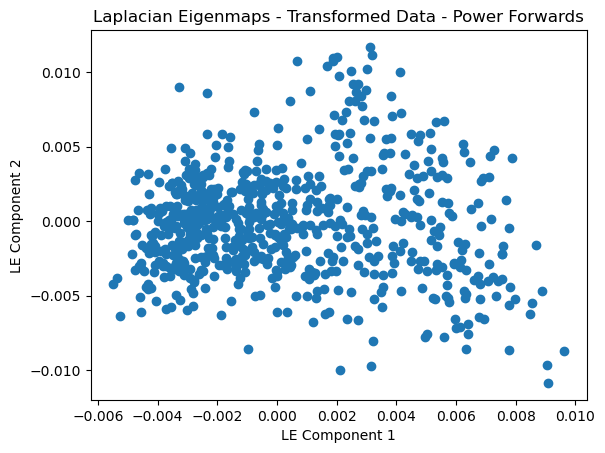

In [29]:
plt.scatter(le_df['LE_Component_1'], le_df['LE_Component_2'])
plt.title(f'Laplacian Eigenmaps - Transformed Data - Power Forwards')
plt.xlabel('LE Component 1')
plt.ylabel('LE Component 2')
plt.show()

In [30]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook
from bokeh.models import ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.plotting import figure, show
from bokeh.models import Slider
from bokeh.layouts import column
from bokeh.io import show
from bokeh.models import Slider, CustomJS
from scipy.stats import pearsonr

In [31]:
le_df['Season'] = list(le_df.reset_index()['Roster'].apply(lambda roster: str(roster)[:4]))
le_df['Season'] = le_df['Season'].apply(lambda season: int(season)).drop(columns=['index'])

In [32]:
le_df

,index,LE_Component_1,LE_Component_2,PC1,PC2,PC3,PC4,PC5,% of FGA by Distance - 3P,Win_Percentage,Season
Roster,,,,,,,,,,,
2001MIA,0,-0.003613,-0.000488,-2.465754,0.106456,0.493806,1.828757,0.999714,0.176192,0.609756,2001
2001CHI,1,-0.002703,0.000701,-1.844162,0.708831,2.373520,-1.287564,1.537035,0.128284,0.182927,2001
2001PHI,2,-0.004050,-0.005367,-2.453086,-2.611923,0.992510,3.801313,0.533022,0.076487,0.682927,2001
2001NJN,3,-0.003394,-0.002787,-2.382448,-1.392195,0.396630,0.217846,0.635025,0.107388,0.317073,2001
2001GSW,4,-0.001157,-0.002348,-0.593736,-1.086280,0.347732,2.869617,1.619617,0.104155,0.207317,2001
...,...,...,...,...,...,...,...,...,...,...,...
2024MIL,710,0.007169,0.000167,4.010771,0.639206,1.251432,0.474986,-1.086633,0.353932,0.597561,2024
2024MEM,711,0.007100,0.002961,4.218388,1.374883,-1.153703,0.259946,1.637849,0.333652,0.329268,2024
2024OKC,712,0.005757,0.000536,3.233831,0.524842,2.037484,0.276650,-1.424424,0.295815,0.695122,2024


In [65]:
# Season Slider graph

# Assuming 'Season' column exists in le_df and contains the season info
# Creating a ColumnDataSource for Bokeh with the full dataset
source = ColumnDataSource(le_df)

# Creating another ColumnDataSource for filtered data
filtered_source = ColumnDataSource(data=source.data)

# Creating padding for the bounds of the axes
x_padding = (le_df['LE_Component_1'].max() - le_df['LE_Component_1'].min()) * 0.1
y_padding = (le_df['LE_Component_2'].max() - le_df['LE_Component_2'].min()) * 0.1

# Creating the figure for the bokeh plot
p = figure(
    title='Laplacian Eigenmaps for Aggregate Statistics Within a Roster',
    x_axis_label='Component 1',
    y_axis_label='Component 2',
    width=800,
    height=600,
    tools='pan, wheel_zoom, box_zoom, reset, save',
    x_range = (le_df['LE_Component_1'].min() - x_padding, le_df['LE_Component_1'].max() + x_padding),
    y_range = (le_df['LE_Component_2'].min() - y_padding, le_df['LE_Component_2'].max() + y_padding)
)

# Define a color map based on the Win_Percentage values
mapper = linear_cmap(field_name='Win_Percentage', palette=Viridis256, low=le_df['Win_Percentage'].min(), high=le_df['Win_Percentage'].max())

# Creating the scatter plot
p.scatter(
    x='LE_Component_1',
    y='LE_Component_2',
    source=filtered_source,
    size=10,
    alpha=0.7,
    #color=mapper,
    legend_label='Aggregate Rosters'
    
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster'),
    ('Season', '@Season'),
    ('Win_Percentage', '@Win_Percentage{0.00}')
]
p.add_tools(hover)

# Add color bar
#color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0, 0), title='Win_Percentage')
#p.add_layout(color_bar, 'right')

# Creating a slider for season filtering
slider = Slider(start=le_df['Season'].min(), end=le_df['Season'].max(), value=le_df['Season'].min(), step=1, title='Season')

# JavaScript callback to filter the data
callback = CustomJS(args=dict(source=source, filtered_source=filtered_source, slider=slider), code="""
    const season = slider.value;
    const data = source.data;
    const filtered_data = { LE_Component_1: [], LE_Component_2: [], Win_Percentage: [], Roster: [], Season: [] };

    for (let i = 0; i < data['Season'].length; i++) {
        if (data['Season'][i] === season) {
            filtered_data['LE_Component_1'].push(data['LE_Component_1'][i]);
            filtered_data['LE_Component_2'].push(data['LE_Component_2'][i]);
            filtered_data['Win_Percentage'].push(data['Win_Percentage'][i]);
            filtered_data['Roster'].push(data['Roster'][i]);
            filtered_data['Season'].push(data['Season'][i]);
        }
    }
    filtered_source.data = filtered_data;
    filtered_source.change.emit();
""")

slider.js_on_change('value', callback)

# Layout with the slider and the plot
layout = column(slider, p)

# Show the layout
show(layout)

In [34]:
# Season slider graph with red dot average

# Assuming 'Season' column exists in le_df and contains the season info
# Creating a ColumnDataSource for Bokeh with the full dataset
source = ColumnDataSource(le_df)

# Creating an average source to get the average values for each season
season_avg = le_df.reset_index().groupby('Season')['LE_Component_1', 'LE_Component_2'].mean().reset_index()
avg_source = ColumnDataSource(season_avg)

# Creating another ColumnDataSource for filtered data
filtered_source = ColumnDataSource(data=source.data)
filtered_avg_source = ColumnDataSource(data=dict(LE_Component_1=[], LE_Component_2=[], Season=[]))

# Creating padding for the bounds of the axes
x_padding = (le_df['LE_Component_1'].max() - le_df['LE_Component_1'].min()) * 0.1
y_padding = (le_df['LE_Component_2'].max() - le_df['LE_Component_2'].min()) * 0.1

# Creating the figure for the bokeh plot
p = figure(
    title='Laplacian Eigenmaps for Aggregate Statistics Within a Roster',
    x_axis_label='Component 1',
    y_axis_label='Component 2',
    width=800,
    height=600,
    tools='pan, wheel_zoom, box_zoom, reset, save',
    x_range = (le_df['LE_Component_1'].min() - x_padding, le_df['LE_Component_1'].max() + x_padding),
    y_range = (le_df['LE_Component_2'].min() - y_padding, le_df['LE_Component_2'].max() + y_padding)
)

# Creating the scatter plot
scatter_points = p.scatter(
    x='LE_Component_1',
    y='LE_Component_2',
    source=filtered_source,
    size=10,
    alpha=0.7,
    legend_label='Aggregate Rosters',
    name='points'
)

# Adding the red dot for the average/mean of each season
avg_scatter = p.scatter(
    x='LE_Component_1',
    y='LE_Component_2',
    source=filtered_avg_source,  # Use the filtered average source
    size=20,
    color='red',
    alpha=1.0,
    legend_label='Seasonal Average'
)

# Adding the hover tool for individual players
hover = HoverTool(renderers=[scatter_points])
hover.tooltips = [
    ('Roster', '@Roster'),
    ('Season', '@Season'),
    ('Win_Percentage', '@Win_Percentage{0.00}')
]
p.add_tools(hover)

# Creating a slider for season filtering
slider = Slider(start=le_df['Season'].min(), end=le_df['Season'].max(), value=le_df['Season'].min(), step=1, title='Season')

# JavaScript callback to filter the data
callback = CustomJS(args=dict(
    source=source,
    filtered_source=filtered_source,
    avg_source=avg_source,
    filtered_avg_source=filtered_avg_source,
    slider=slider
), code="""
    const season = slider.value;
    const data = source.data;
    const filtered_data = {
        LE_Component_1: [],
        LE_Component_2: [],
        Win_Percentage: [],
        Roster: [],
        Season: []
    };
    
    // Filter main data points
    for (let i = 0; i < data['Season'].length; i++) {
        if (parseInt(data['Season'][i]) === parseInt(season)) {
            filtered_data['LE_Component_1'].push(data['LE_Component_1'][i]);
            filtered_data['LE_Component_2'].push(data['LE_Component_2'][i]);
            filtered_data['Win_Percentage'].push(data['Win_Percentage'][i]);
            filtered_data['Roster'].push(data['Roster'][i]);
            filtered_data['Season'].push(data['Season'][i]);
        }
    }
    
    // Filter average data
    const avg_data = avg_source.data;
    const filtered_avg_data = {
        LE_Component_1: [],
        LE_Component_2: [],
        Season: []
    };
    
    for (let i = 0; i < avg_data['Season'].length; i++) {
        if (parseInt(avg_data['Season'][i]) === parseInt(season)) {
            filtered_avg_data['LE_Component_1'].push(avg_data['LE_Component_1'][i]);
            filtered_avg_data['LE_Component_2'].push(avg_data['LE_Component_2'][i]);
            filtered_avg_data['Season'].push(avg_data['Season'][i]);
        }
    }
    
    filtered_source.data = filtered_data;
    filtered_avg_source.data = filtered_avg_data;
    
    filtered_source.change.emit();
    filtered_avg_source.change.emit();
""")

slider.js_on_change('value', callback)

# Layout with the slider and the plot
layout = column(slider, p)

# Show the layout
#show(layout)

C:\Users\vaugh\AppData\Local\Temp\ipykernel_11480\4138425222.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  season_avg = le_df.reset_index().groupby('Season')['LE_Component_1', 'LE_Component_2'].mean().reset_index()


In [32]:
# Plotting season averages in scatterplot

# Creating an average source to get the average values for each season
season_avg = le_df.reset_index().groupby('Season')['LE_Component_1', 'LE_Component_2'].mean().reset_index()
source = ColumnDataSource(season_avg)

# Creating padding for the bounds of the axes
x_padding = (le_df['LE_Component_1'].max() - le_df['LE_Component_1'].min()) * 0.1
y_padding = (le_df['LE_Component_2'].max() - le_df['LE_Component_2'].min()) * 0.1

# Create the figure
p = figure(
    title='Progression of Seasonal Averages',
    x_axis_label='Component 1',
    y_axis_label='Component 2',
    width=800,
    height=600,
    tools='pan, wheel_zoom, box_zoom, reset, save',
    x_range=(le_df['LE_Component_1'].min() - x_padding, le_df['LE_Component_1'].max() + x_padding),
    y_range=(le_df['LE_Component_2'].min() - y_padding, le_df['LE_Component_2'].max() + y_padding)
)

# Define a color map based on the Win_Percentage values
mapper = linear_cmap(field_name='Season', palette=Viridis256, low=le_df['Season'].min(), high=le_df['Season'].max())

# Add the scatter points for averages
scatter = p.scatter(
    x='LE_Component_1',
    y='LE_Component_2',
    source=source,
    size=15,
    color=mapper,
    alpha=0.8,
    legend_label='Season Averages'
)

# Add the connecting lines between seasons
# We need to sort by season to ensure correct line progression
sorted_avg = season_avg.sort_values('Season')
p.line(
    x=sorted_avg['LE_Component_1'],
    y=sorted_avg['LE_Component_2'],
    line_color='blue',
    line_width=2,
    alpha=0.6,
    legend_label='Progression'
)

# Add hover tool
hover = HoverTool(renderers=[scatter])
hover.tooltips = [
    ('Season', '@Season')
]
p.add_tools(hover)

# Configure legend
p.legend.location = "top_right"
p.legend.click_policy = "hide"

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title='Season')
p.add_layout(color_bar, 'right')

# Show the plot
show(p)

C:\Users\vaugh\AppData\Local\Temp\ipykernel_7832\4069288261.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  season_avg = le_df.reset_index().groupby('Season')['LE_Component_1', 'LE_Component_2'].mean().reset_index()


In [36]:
# Season slider with just the average dot

# Assuming 'Season' column exists in le_df and contains the season info
# Creating a ColumnDataSource for Bokeh with the full dataset
source = ColumnDataSource(le_df)

# Creating an average source to get the average values for each season
season_avg = le_df.reset_index().groupby('Season')['LE_Component_1', 'LE_Component_2'].mean().reset_index()
avg_source = ColumnDataSource(season_avg)

# Creating another ColumnDataSource for filtered data
filtered_source = ColumnDataSource(data=source.data)
filtered_avg_source = ColumnDataSource(data=dict(LE_Component_1=[], LE_Component_2=[], Season=[]))

# Creating padding for the bounds of the axes
x_padding = (le_df['LE_Component_1'].max() - le_df['LE_Component_1'].min()) * 0.1
y_padding = (le_df['LE_Component_2'].max() - le_df['LE_Component_2'].min()) * 0.1

# Creating the figure for the bokeh plot
p = figure(
    title='Laplacian Eigenmaps for Aggregate Statistics Within a Roster',
    x_axis_label='Component 1',
    y_axis_label='Component 2',
    width=800,
    height=600,
    tools='pan, wheel_zoom, box_zoom, reset, save',
    x_range = (le_df['LE_Component_1'].min() - x_padding, le_df['LE_Component_1'].max() + x_padding),
    y_range = (le_df['LE_Component_2'].min() - y_padding, le_df['LE_Component_2'].max() + y_padding)
)

# Adding the red dot for the average/mean of each season
avg_scatter = p.scatter(
    x='LE_Component_1',
    y='LE_Component_2',
    source=filtered_avg_source,  # Use the filtered average source
    size=20,
    color='red',
    alpha=1.0,
    legend_label='Seasonal Average'
)

# Creating a slider for season filtering
slider = Slider(start=le_df['Season'].min(), end=le_df['Season'].max(), value=le_df['Season'].min(), step=1, title='Season')

# JavaScript callback to filter the data
callback = CustomJS(args=dict(
    source=source,
    filtered_source=filtered_source,
    avg_source=avg_source,
    filtered_avg_source=filtered_avg_source,
    slider=slider
), code="""
    const season = slider.value;
    const data = source.data;
    const filtered_data = {
        LE_Component_1: [],
        LE_Component_2: [],
        Win_Percentage: [],
        Roster: [],
        Season: []
    };
    
    // Filter main data points
    for (let i = 0; i < data['Season'].length; i++) {
        if (parseInt(data['Season'][i]) === parseInt(season)) {
            filtered_data['LE_Component_1'].push(data['LE_Component_1'][i]);
            filtered_data['LE_Component_2'].push(data['LE_Component_2'][i]);
            filtered_data['Win_Percentage'].push(data['Win_Percentage'][i]);
            filtered_data['Roster'].push(data['Roster'][i]);
            filtered_data['Season'].push(data['Season'][i]);
        }
    }
    
    // Filter average data
    const avg_data = avg_source.data;
    const filtered_avg_data = {
        LE_Component_1: [],
        LE_Component_2: [],
        Season: []
    };
    
    for (let i = 0; i < avg_data['Season'].length; i++) {
        if (parseInt(avg_data['Season'][i]) === parseInt(season)) {
            filtered_avg_data['LE_Component_1'].push(avg_data['LE_Component_1'][i]);
            filtered_avg_data['LE_Component_2'].push(avg_data['LE_Component_2'][i]);
            filtered_avg_data['Season'].push(avg_data['Season'][i]);
        }
    }
    
    filtered_source.data = filtered_data;
    filtered_avg_source.data = filtered_avg_data;
    
    filtered_source.change.emit();
    filtered_avg_source.change.emit();
""")

slider.js_on_change('value', callback)

# Layout with the slider and the plot
layout = column(slider, p)

# Show the layout
show(layout)

C:\Users\vaugh\AppData\Local\Temp\ipykernel_11480\4277806910.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  season_avg = le_df.reset_index().groupby('Season')['LE_Component_1', 'LE_Component_2'].mean().reset_index()


In [33]:
# Simple LE graph overlayed with season colorbar

# Creating a ColumnDataSource for Bokeh
source = ColumnDataSource(le_df)

# Creating padding for the bounds of the axes
x_padding = (le_df['LE_Component_1'].max() - le_df['LE_Component_1'].min()) * 0.1
y_padding = (le_df['LE_Component_2'].max() - le_df['LE_Component_2'].min()) * 0.1

# Creating the figure for the bokeh plot
p = figure(
    title = 'Laplacian Eigenmaps for Aggregate Statistics Within a Roster',
    x_axis_label = 'Component 1',
    y_axis_label = 'Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save',
    x_range = (le_df['LE_Component_1'].min() - x_padding, le_df['LE_Component_1'].max() + x_padding),
    y_range = (le_df['LE_Component_2'].min() - y_padding, le_df['LE_Component_2'].max() + y_padding)
)

# Define a color map based on the USG% values
mapper = linear_cmap(field_name='Season', palette=Viridis256, low=le_df['Season'].min(), high=le_df['Season'].max())

# Creating the scatter plot
p.scatter(
    x = 'LE_Component_1',
    y = 'LE_Component_2',
    source = source,
    size = 10,
    alpha = 0.7,
    color = mapper,
    legend_label = 'Aggregate Rosters'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster')
                 ]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title='Season')
p.add_layout(color_bar, 'right')

show(p)

In [75]:
# Simple LE graph overlayed with 3PA colorbar

# Creating a ColumnDataSource for Bokeh
source = ColumnDataSource(le_df)

# Creating padding for the bounds of the axes
x_padding = (le_df['LE_Component_1'].max() - le_df['LE_Component_1'].min()) * 0.1
y_padding = (le_df['LE_Component_2'].max() - le_df['LE_Component_2'].min()) * 0.1

# Creating the figure for the bokeh plot
p = figure(
    title = 'Laplacian Eigenmaps for Aggregate Statistics Within a Roster',
    x_axis_label = 'Component 1',
    y_axis_label = 'Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save',
    x_range = (le_df['LE_Component_1'].min() - x_padding, le_df['LE_Component_1'].max() + x_padding),
    y_range = (le_df['LE_Component_2'].min() - y_padding, le_df['LE_Component_2'].max() + y_padding)
)

# Define a color map based on the USG% values
mapper = linear_cmap(field_name='% of FGA by Distance - 3P', palette=Viridis256, low=le_df['% of FGA by Distance - 3P'].min(), high=le_df['% of FGA by Distance - 3P'].max())

# Creating the scatter plot
p.scatter(
    x = 'LE_Component_1',
    y = 'LE_Component_2',
    source = source,
    size = 10,
    alpha = 0.7,
    color = mapper,
    legend_label = 'Aggregate Rosters'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster'),
    ('% 3P', '@{% of FGA by Distance - 3P}')
                 ]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title='% of FGA by Distance - 3P')
p.add_layout(color_bar, 'right')

show(p)

In [33]:
# Simple LE graph overlayed with 3PA colorbar, but with a range of 3P values

# Creating a ColumnDataSource for Bokeh
specified_range = [.1, .11]
source = ColumnDataSource(le_df[(le_df['% of FGA by Distance - 3P'] >= specified_range[0]) & (le_df['% of FGA by Distance - 3P'] <= specified_range[1])])

# Creating padding for the bounds of the axes
x_padding = (le_df['LE_Component_1'].max() - le_df['LE_Component_1'].min()) * 0.1
y_padding = (le_df['LE_Component_2'].max() - le_df['LE_Component_2'].min()) * 0.1

# Creating the figure for the bokeh plot
p = figure(
    title = f'LE for Aggregate Statistics Within a Roster - 3P Colorbar Ranging from {specified_range[0] * 100}% to {specified_range[1]  * 100}% of Shots Taken',
    x_axis_label = 'Component 1',
    y_axis_label = 'Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save',
    x_range = (le_df['LE_Component_1'].min() - x_padding, le_df['LE_Component_1'].max() + x_padding),
    y_range = (le_df['LE_Component_2'].min() - y_padding, le_df['LE_Component_2'].max() + y_padding)
)

# Define a color map based on the USG% values
mapper = linear_cmap(field_name='% of FGA by Distance - 3P', palette=Viridis256, low=le_df['% of FGA by Distance - 3P'].min(), high=le_df['% of FGA by Distance - 3P'].max())

# Creating the scatter plot
p.scatter(
    x = 'LE_Component_1',
    y = 'LE_Component_2',
    source = source,
    size = 10,
    alpha = 0.7,
    color = mapper,
    legend_label = 'Aggregate Rosters'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster'),
    ('% 3P', '@{% of FGA by Distance - 3P}')
                 ]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title='% of FGA by Distance - 3P')
p.add_layout(color_bar, 'right')

show(p)

In [83]:
le_df

,index,LE_Component_1,LE_Component_2,PC1,PC2,PC3,PC4,PC5,% of FGA by Distance - 3P,Win_Percentage,Season
Roster,,,,,,,,,,,
2001MIA,0,-0.003613,-0.000488,-2.465754,0.106456,0.493806,1.828757,0.999714,0.176192,0.609756,2001
2001CHI,1,-0.002703,0.000701,-1.844162,0.708831,2.373520,-1.287564,1.537035,0.128284,0.182927,2001
2001PHI,2,-0.004050,-0.005367,-2.453086,-2.611923,0.992510,3.801313,0.533022,0.076487,0.682927,2001
2001NJN,3,-0.003394,-0.002787,-2.382448,-1.392195,0.396630,0.217846,0.635025,0.107388,0.317073,2001
2001GSW,4,-0.001157,-0.002348,-0.593736,-1.086280,0.347732,2.869617,1.619617,0.104155,0.207317,2001
...,...,...,...,...,...,...,...,...,...,...,...
2024MIL,710,0.007169,0.000167,4.010771,0.639206,1.251432,0.474986,-1.086633,0.353932,0.597561,2024
2024MEM,711,0.007100,0.002961,4.218388,1.374883,-1.153703,0.259946,1.637849,0.333652,0.329268,2024
2024OKC,712,0.005757,0.000536,3.233831,0.524842,2.037484,0.276650,-1.424424,0.295815,0.695122,2024


In [84]:
season_D3P_corr = pearsonr(le_df['% of FGA by Distance - 3P'], le_df['Season'])

In [86]:
season_D3P_corr[0]

0.8246545344487415

In [88]:
# PC1 vs PC2 overlayed with season colorbar

# Creating a ColumnDataSource for Bokeh
source = ColumnDataSource(le_df)

# Creating the figure for the bokeh plot
p = figure(
    title = 'Aggregate Statistics by Roster - Principal Component Analysis Plotted',
    x_axis_label = 'Principal Component 1',
    y_axis_label = 'Principal Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save'
)

# Define a color map based on the USG% values
mapper = linear_cmap(field_name='Season', palette=Viridis256, low=le_df['Season'].min(), high=le_df['Season'].max())

# Creating the scatter plot
p.scatter(
    x = 'PC1',
    y = 'PC2',
    source = source,
    size = 10,
    alpha = 0.7,
    color = mapper
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster')
                 ]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title='Season')
p.add_layout(color_bar, 'right')

show(p)

In [92]:
PC1_LE1_corr = pearsonr(le_df['PC1'], le_df['LE_Component_1'])[0]
PC2_LE2_corr = pearsonr(le_df['PC2'], le_df['LE_Component_2'])[0]

In [93]:
PC1_LE1_corr

0.9941471669701489

In [94]:
PC2_LE2_corr

0.9735664854988366

In [36]:
# Simple LE graph overlayed with PC colorbar

# Creating a ColumnDataSource for Bokeh
source = ColumnDataSource(le_df)

# Creating padding for the bounds of the axes
x_padding = (le_df['LE_Component_1'].max() - le_df['LE_Component_1'].min()) * 0.1
y_padding = (le_df['LE_Component_2'].max() - le_df['LE_Component_2'].min()) * 0.1

# Creating the figure for the bokeh plot
p = figure(
    title = 'Laplacian Eigenmaps for Aggregate Statistics Within a Roster',
    x_axis_label = 'Component 1',
    y_axis_label = 'Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save',
    x_range = (le_df['LE_Component_1'].min() - x_padding, le_df['LE_Component_1'].max() + x_padding),
    y_range = (le_df['LE_Component_2'].min() - y_padding, le_df['LE_Component_2'].max() + y_padding)
)

# Define a color map based on the USG% values
mapper = linear_cmap(field_name='PC2', palette=Viridis256, low=le_df['PC2'].min(), high=le_df['PC2'].max())

# Creating the scatter plot
p.scatter(
    x = 'LE_Component_1',
    y = 'LE_Component_2',
    source = source,
    size = 10,
    alpha = 0.7,
    color = mapper,
    legend_label = 'Aggregate Rosters'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster'),
    ('PC2', '@PC2')
                 ]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title='PC2')
p.add_layout(color_bar, 'right')

show(p)

In [23]:
aggregates_df

,USG%,FGA,BLK,STL,TOV,AST,% of FG Ast'd - 3P,% of FG Ast'd - 2P,FTr,Corner 3s - %3PA,% of FGA by Distance - 3P,% of FGA by Distance - 16-3P,% of FGA by Distance - 10-16,% of FGA by Distance - 3-10,% of FGA by Distance - 0-3,TRB
Roster,,,,,,,,,,,,,,,,
2001MIA,14.718647,11.119506,0.679186,1.113648,1.939690,2.911115,0.336181,0.406438,0.226507,0.094051,0.176192,0.161776,0.107894,0.108278,0.183090,5.983500
2001CHI,14.373478,11.385495,0.540390,1.208207,2.029441,3.366040,0.537979,0.435861,0.199752,0.195628,0.128284,0.178461,0.114477,0.094424,0.184744,5.110495
2001PHI,14.281575,11.065760,0.911429,1.192326,2.257909,2.994245,0.423150,0.406195,0.279576,0.122912,0.076487,0.117604,0.157956,0.167588,0.210909,6.877866
2001NJN,14.710140,11.891080,0.712652,1.185972,1.967071,2.679632,0.501012,0.414561,0.240679,0.119460,0.107388,0.168473,0.095731,0.102919,0.246872,5.798146
2001GSW,14.555899,12.653450,0.662977,1.211110,2.165906,3.132281,0.492624,0.377077,0.237184,0.097077,0.104155,0.161265,0.114217,0.160751,0.174698,7.029386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024MEM,16.017445,14.050917,0.711016,1.043312,2.243979,3.936655,0.583392,0.347840,0.176838,0.142844,0.333652,0.023634,0.045282,0.142604,0.147163,5.271173
2024OKC,14.843881,13.339354,0.953770,1.283633,1.702537,3.834423,0.628897,0.411209,0.154182,0.179041,0.295815,0.040103,0.074911,0.131444,0.188559,5.992650
2024BRK,14.749015,13.242605,0.694353,1.014782,1.786429,4.220275,0.635657,0.374552,0.159040,0.233627,0.335964,0.034923,0.064597,0.136117,0.173274,5.725334


In [26]:
# Creating individual scatter plots for each stat to see the trend over time
agg_df = aggregates_df.copy()
agg_df['Season'] = list(agg_df.reset_index()['Roster'].apply(lambda roster: str(roster)[:4]))
agg_df['Season'] = agg_df['Season'].apply(lambda season: int(season))

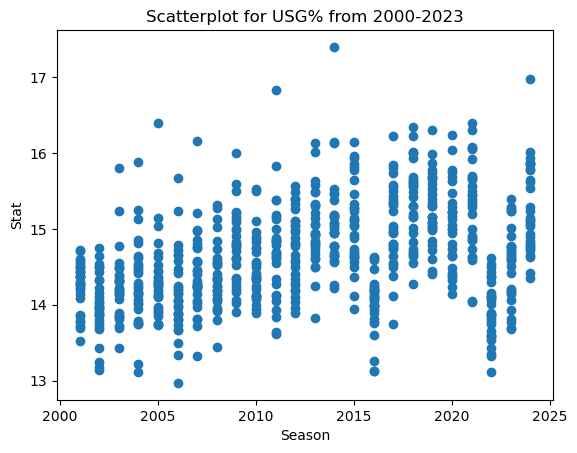

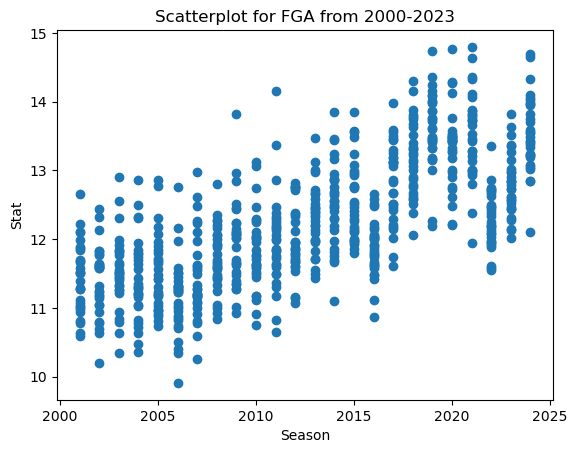

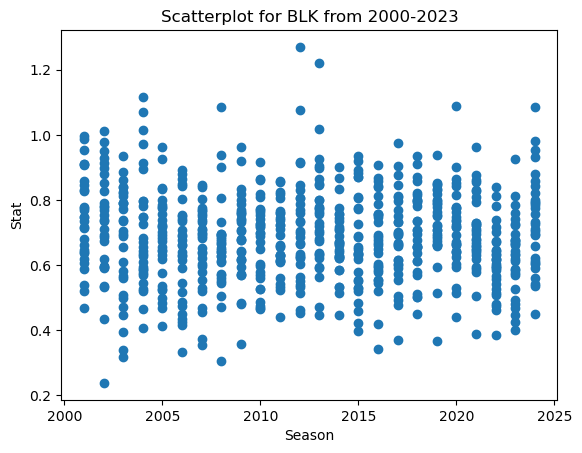

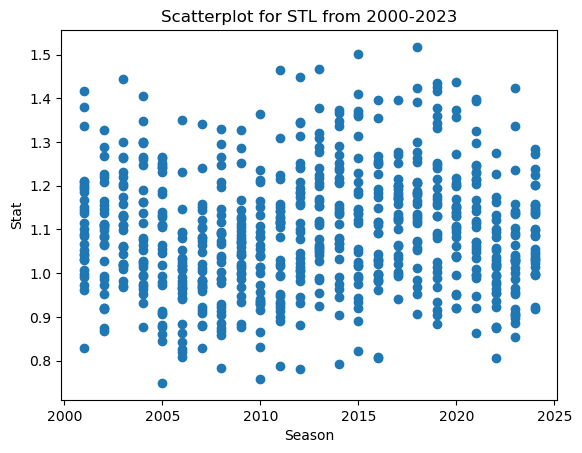

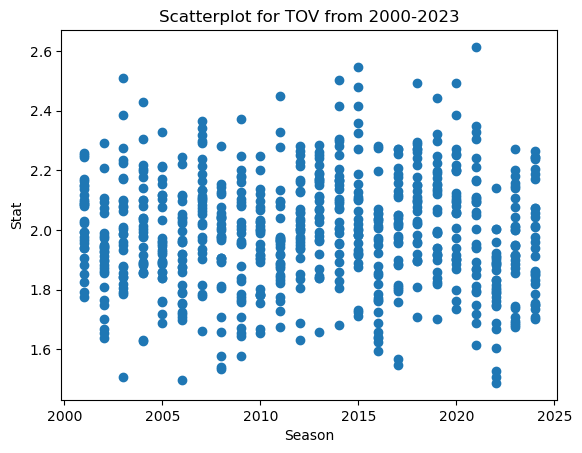

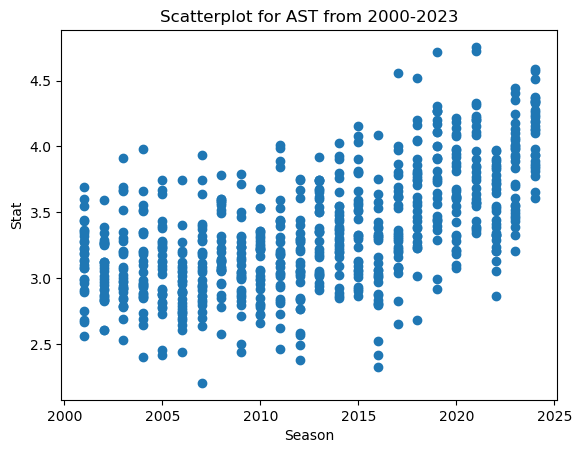

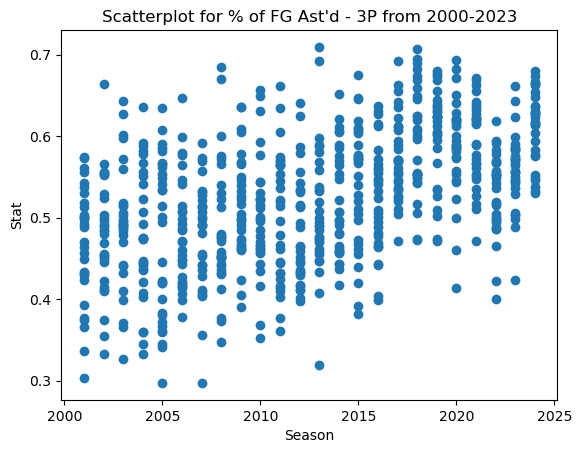

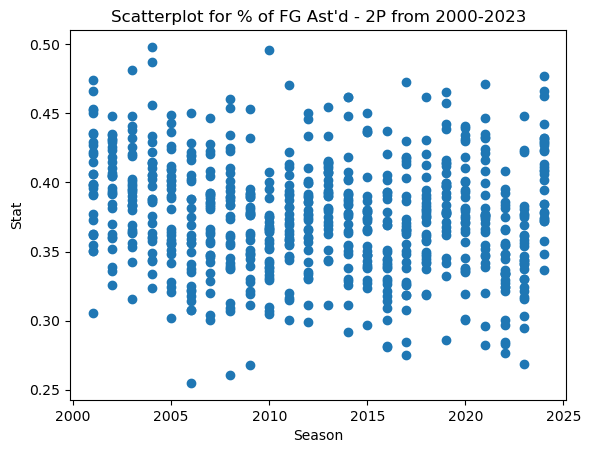

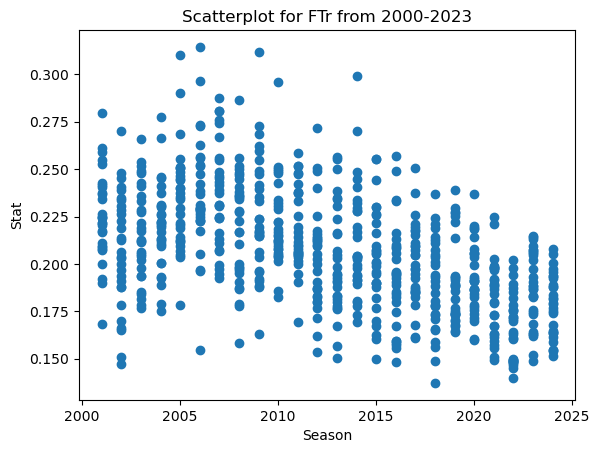

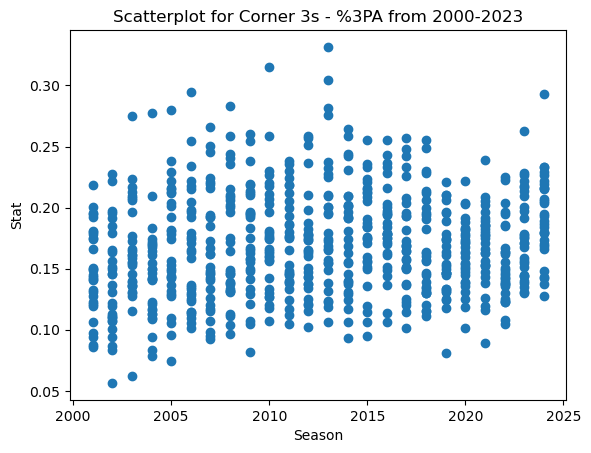

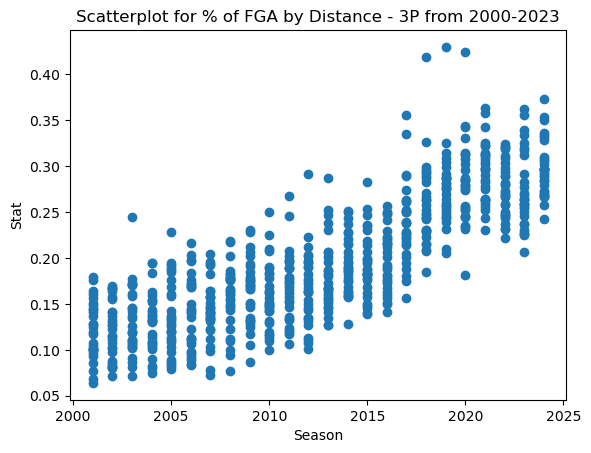

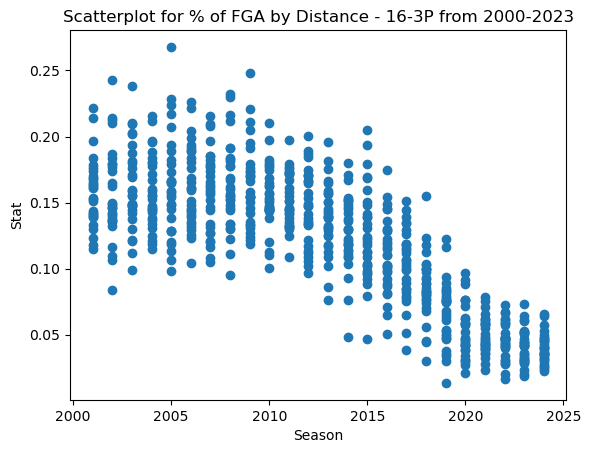

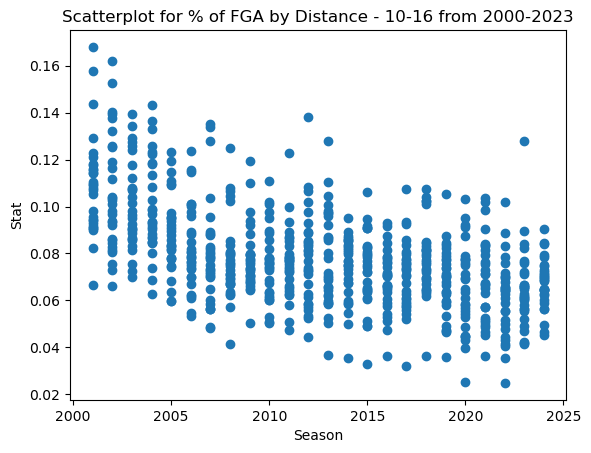

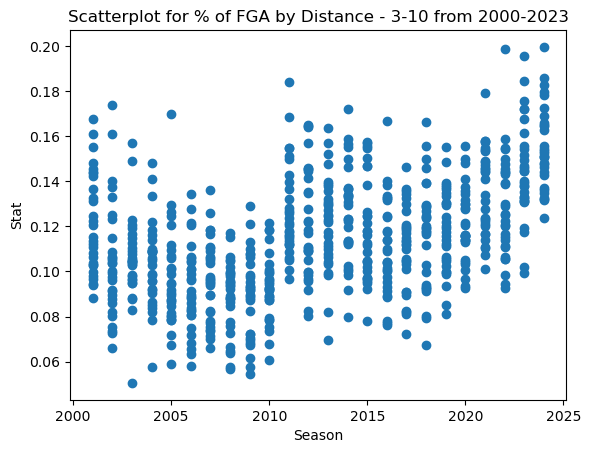

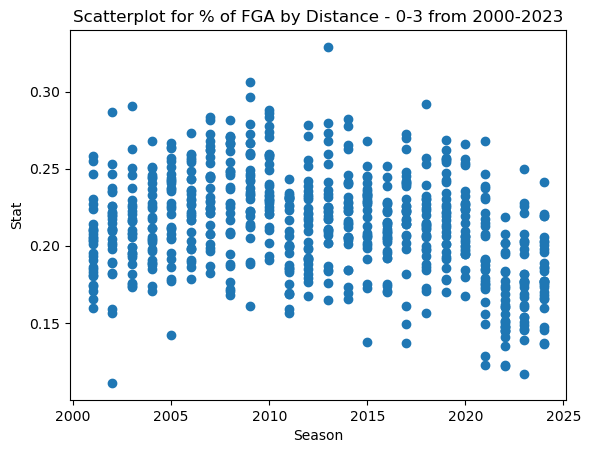

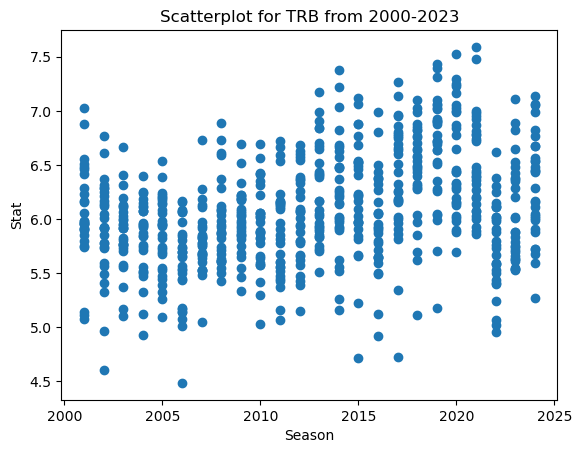

In [27]:
for stat in [col for col in agg_df.columns if col != "Season"]:
    plt.scatter(agg_df['Season'], agg_df[stat])
    plt.title(f'Scatterplot for {stat} from 2000-2023')
    plt.xlabel('Season')
    plt.ylabel(f'Stat')
    plt.show()

<Figure size 1000x500 with 0 Axes>

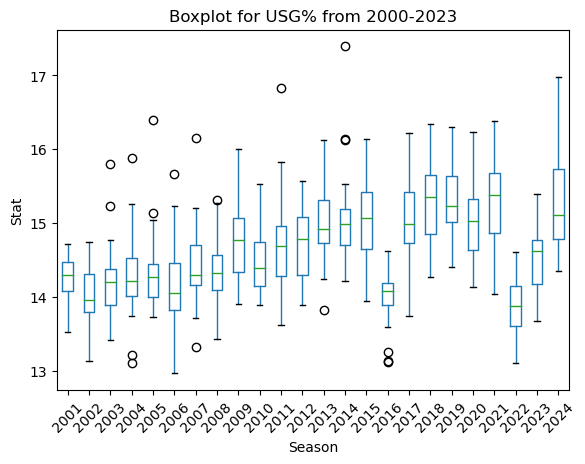

<Figure size 1000x500 with 0 Axes>

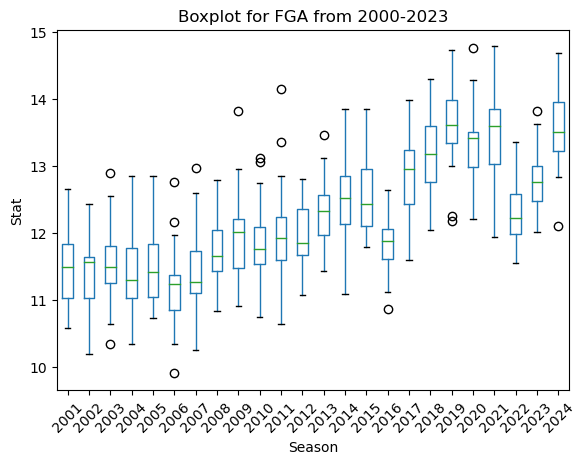

<Figure size 1000x500 with 0 Axes>

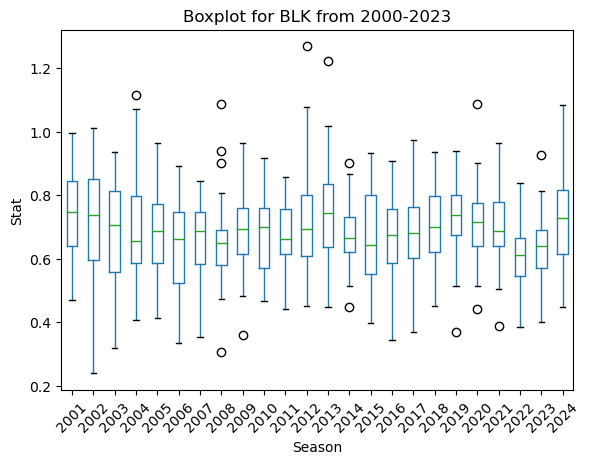

<Figure size 1000x500 with 0 Axes>

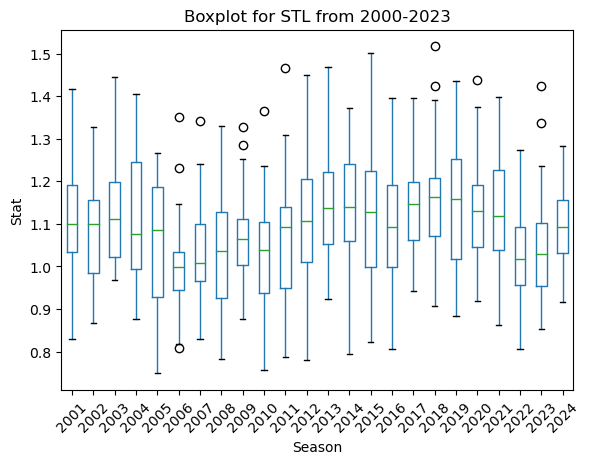

<Figure size 1000x500 with 0 Axes>

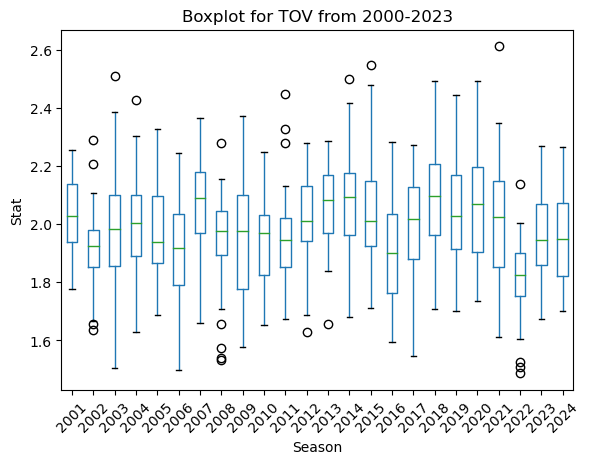

<Figure size 1000x500 with 0 Axes>

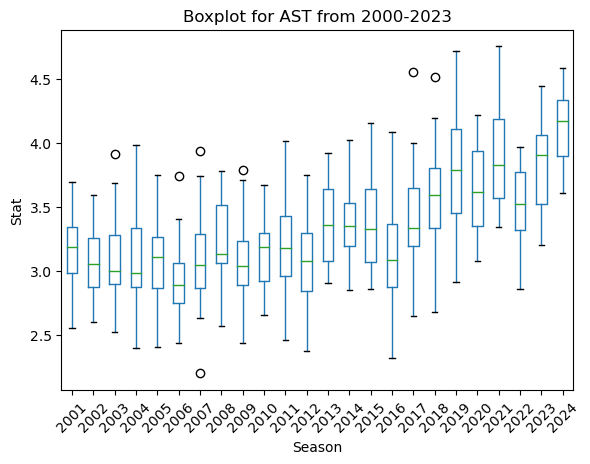

<Figure size 1000x500 with 0 Axes>

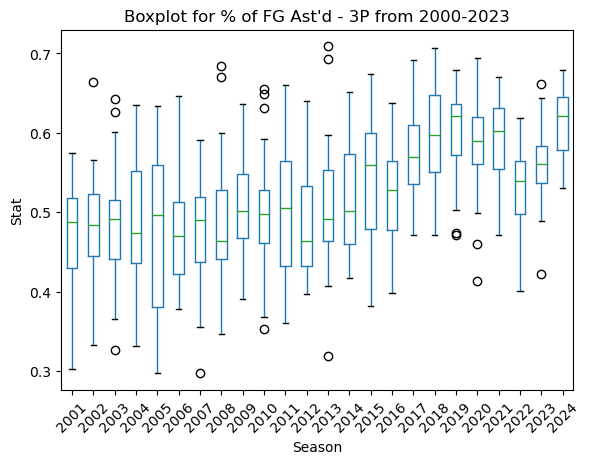

<Figure size 1000x500 with 0 Axes>

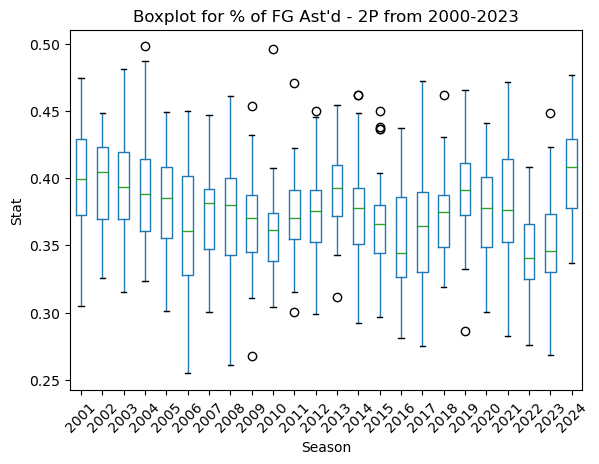

<Figure size 1000x500 with 0 Axes>

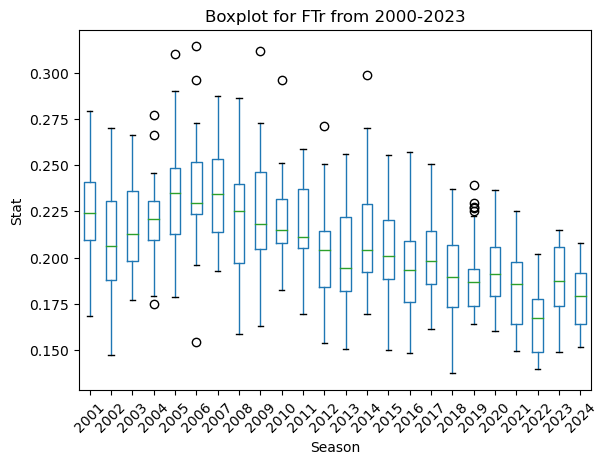

<Figure size 1000x500 with 0 Axes>

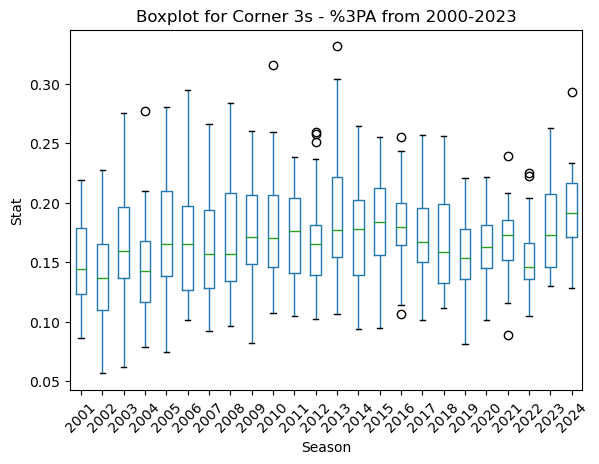

<Figure size 1000x500 with 0 Axes>

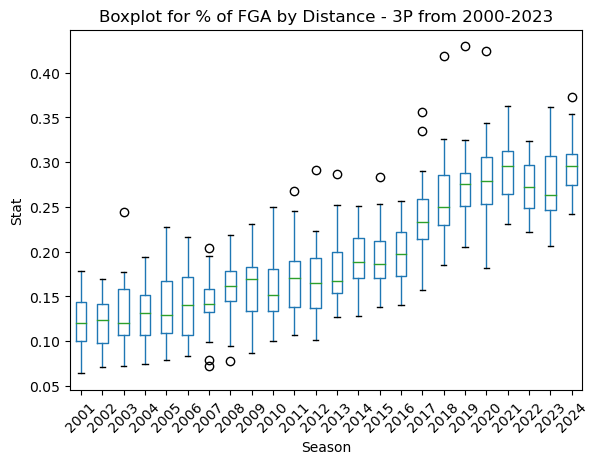

<Figure size 1000x500 with 0 Axes>

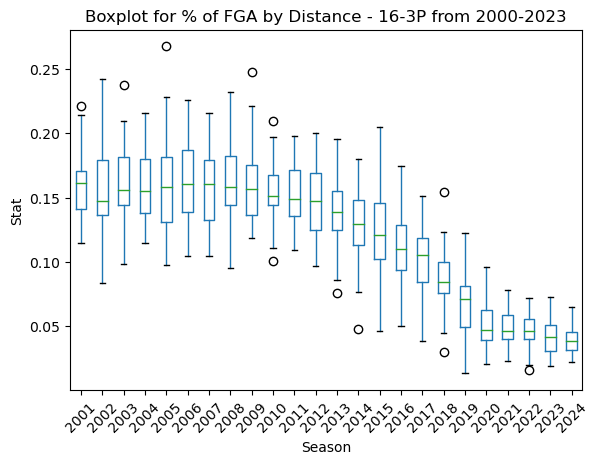

<Figure size 1000x500 with 0 Axes>

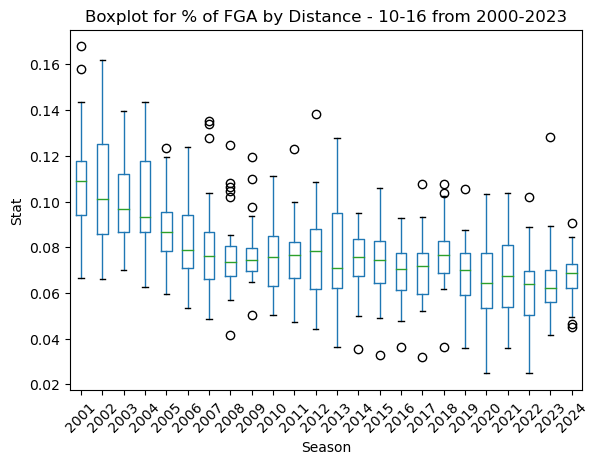

<Figure size 1000x500 with 0 Axes>

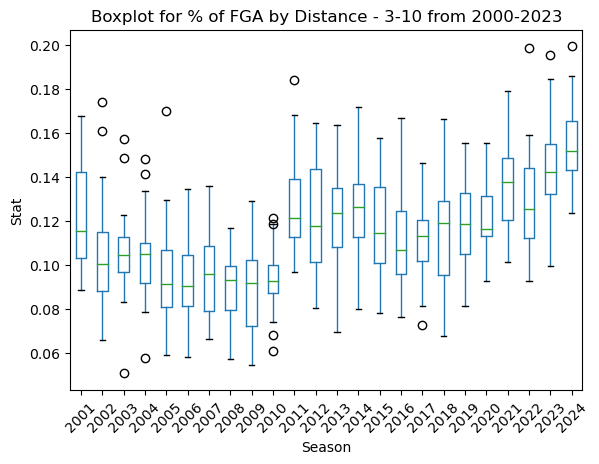

<Figure size 1000x500 with 0 Axes>

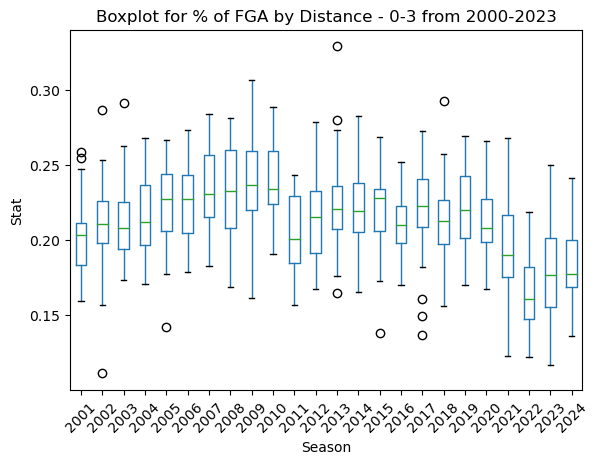

<Figure size 1000x500 with 0 Axes>

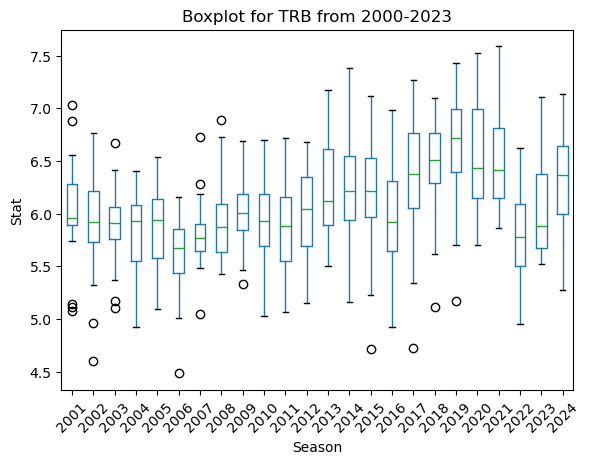

In [29]:
for stat in [col for col in agg_df.columns if col != "Season"]:
    plt.figure(figsize=(10, 5))
    agg_df.boxplot(column = stat, by='Season', grid=False)
    plt.title(f'Boxplot for {stat} from 2000-2023')
    plt.suptitle('')
    plt.xlabel('Season')
    plt.ylabel(f'Stat')
    plt.xticks(rotation = 45)
    plt.show()